In [39]:
# importing libraries
import os, warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import gridspec
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
warnings.filterwarnings('ignore')

In [4]:
tf.__version__

'2.12.0'

In [15]:
# Reproductability
def set_seed(seed=31415):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [16]:
# set matplotlib defaults
plt.rc('figure', autolayout = True)
plt.rc('axes', titlesize = 10, titleweight = 'bold', titlepad = 10, labelsize = 10, labelweight = 'bold')
plt.rc('image', cmap = 'magma')


In [17]:
# Load training and validation sets

ds_train = image_dataset_from_directory("../input/car-or-truck/train",
                                        labels='inferred',
                                        label_mode='binary',
                                        image_size=[128, 128],
                                        interpolation='nearest',
                                        batch_size=64,
                                        shuffle=True)

Found 5117 files belonging to 2 classes.


In [18]:
ds_valid = image_dataset_from_directory("../input/car-or-truck/valid",
                                        labels='inferred',
                                        label_mode='binary',
                                        image_size=[128, 128],
                                        interpolation='nearest',
                                        batch_size=64,
                                        shuffle=False)

Found 5051 files belonging to 2 classes.


In [19]:
# Data Pipeline
def convert_to_float(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, label

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [29]:
# define the model
pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

In [33]:
model = keras.Sequential([
                # Preprocessing
                 preprocessing.RandomFlip('horizontal'), # flip left-to-right
                 preprocessing.RandomContrast(0.5), # contrast change by up tp 50%
                 #base
                 pretrained_base,
                 # Head
                 layers.Flatten(),
                 layers.Dense(units = 6, activation='relu'),
                 layers.Dense(units = 1, activation = 'sigmoid')
])

In [34]:
# train and evaluate

model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['binary_accuracy'])

In [37]:
history = model.fit(ds_train,
                   validation_data = ds_valid,
                   verbose = 1,
                   epochs = 30)

Epoch 1/30
80/80 [==============================] - 74s 906ms/step - loss: 0.5034 - binary_accuracy: 0.7536 - val_loss: 0.4043 - val_binary_accuracy: 0.8262
Epoch 2/30
80/80 [==============================] - 71s 897ms/step - loss: 0.3950 - binary_accuracy: 0.8288 - val_loss: 0.3634 - val_binary_accuracy: 0.8442
Epoch 3/30
80/80 [==============================] - 71s 897ms/step - loss: 0.3603 - binary_accuracy: 0.8511 - val_loss: 0.3380 - val_binary_accuracy: 0.8561
Epoch 4/30
80/80 [==============================] - 71s 898ms/step - loss: 0.3429 - binary_accuracy: 0.8566 - val_loss: 0.3458 - val_binary_accuracy: 0.8489
Epoch 5/30
80/80 [==============================] - 71s 897ms/step - loss: 0.3229 - binary_accuracy: 0.8669 - val_loss: 0.3263 - val_binary_accuracy: 0.8636
Epoch 6/30
80/80 [==============================] - 72s 899ms/step - loss: 0.3003 - binary_accuracy: 0.8757 - val_loss: 0.3146 - val_binary_accuracy: 0.8711
Epoch 7/30
80/80 [==============================] - 72s 90

<Axes: >

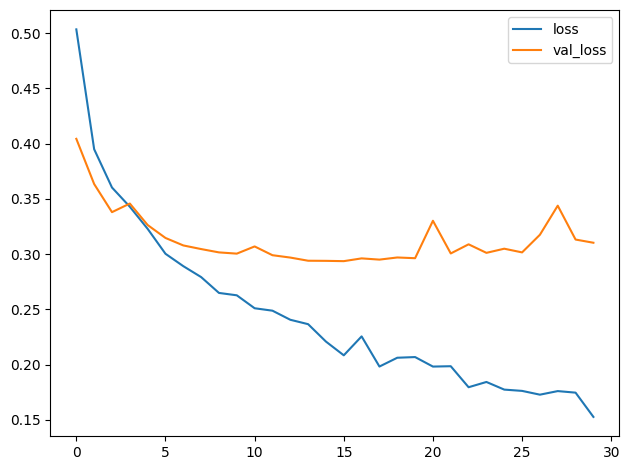

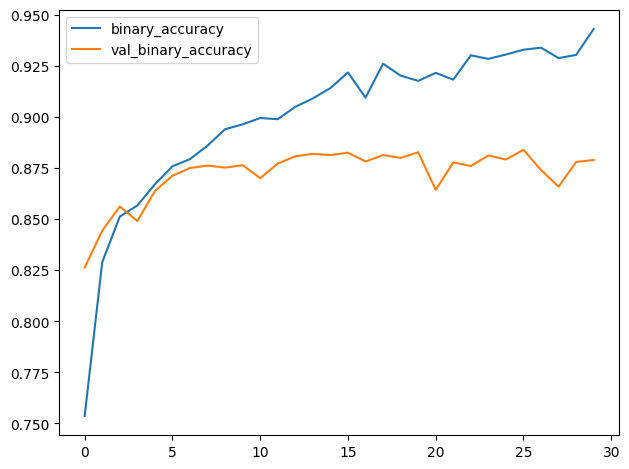

In [42]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:,['binary_accuracy','val_binary_accuracy']].plot()